<a href="https://colab.research.google.com/github/rithinrao/Stack-Overflow-Analysis/blob/main/Group_Project_Adv_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Mounts the files to the drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then we load the data and the glove model

In [ ]:
import pandas as pd
questions = pd.read_csv('/content/drive/My Drive/Analytics in Practice Project/NeuralNetworkStuff/PythonQuestions.csv',index_col=False)
glove = f = open('/content/drive/My Drive/Analytics in Practice Project/NeuralNetworkStuff/glove.6B.100d.txt' , encoding='utf-8')

FileNotFoundError: ignored

In [ ]:
for col in questions.columns: 
    print(col) 

print(questions.head())

question_id
title
ower_rep
user_type
accept_rate
is_answered
answer_id
view_count
answer_count
score
tags
created_date
edited_date
activity_date
closed_date
closed_reason
   question_id  ...  closed_reason
0          337  ...  Opinion-based
1          469  ...            NaN
2          502  ...            NaN
3          535  ...            NaN
4          594  ...            NaN

[5 rows x 16 columns]


In [ ]:
questions.describe()

,question_id,ower_rep,accept_rate,is_answered,answer_id,view_count,answer_count,score,created_date,edited_date,activity_date,closed_date
count,5.471430e+05,537351.000000,412731.000000,547143.000000,3.403520e+05,5.471430e+05,547143.000000,547143.000000,5.471430e+05,3.184760e+05,5.471430e+05,3.208500e+04
mean,2.171918e+07,5837.821033,69.784661,0.818391,2.041483e+07,5.445519e+03,1.840137,4.857611,1.388255e+09,1.413676e+09,1.417130e+09,1.416212e+09
std,1.127066e+07,21375.110921,22.283603,0.385522,1.095812e+07,4.270934e+04,1.738778,44.303655,5.978182e+07,6.716346e+07,7.076134e+07,6.139365e+07
min,3.370000e+02,1.000000,0.000000,0.000000,3.420000e+02,2.000000e+00,0.000000,-64.000000,1.217648e+09,1.218145e+09,1.220643e+09,1.222724e+09
25%,1.319430e+07,93.000000,58.000000,1.000000,1.153286e+07,1.540000e+02,1.000000,0.000000,1.351855e+09,1.370985e+09,1.372882e+09,1.375988e+09
50%,2.259895e+07,663.000000,74.000000,1.000000,2.108285e+07,6.180000e+02,1.000000,1.000000,1.395620e+09,1.416916e+09,1.416599e+09,1.407887e+09
75%,3.025229e+07,3289.000000,86.000000,1.000000,2.932263e+07,2.022000e+03,2.000000,3.000000,1.431669e+09,1.451053e+09,1.450497e+09,1.446028e+09
max,6.033118e+07,793640.000000,100.000000,1.000000,6.033083e+07,4.190047e+06,191.000000,9876.000000,1.582251e+09,1.582251e+09,1.582251e+09,1.582250e+09


In [ ]:
import keras
keras.__version__

'2.3.1'

In [ ]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In this section we take the title of the question and tokenize it so we can use it for training and validation. The plan it to use a pretrained embedding layer to complement our model.

The goal is to predict if a question will be answered based on the title of the question

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


maxlen = 25  # We will cut title after 25 words
training_samples = 20000  # We will be training on 20k samples
validation_samples = 10000  # We will be validating on 10k samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset


#load the question title and the boolean answer
texts = questions['title']
labels = questions['is_answered']


#build the tokenizers
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)






# Split the data into a training set and a validation set

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 54896 unique tokens.
Shape of data tensor: (547143, 25)
Shape of label tensor: (547143,)


Create An Embedding Layer based on the book

In [ ]:
import os
embeddings_index = {}

for line in glove:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


Create a base set ot layers

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,080,065
Trainable params: 1,080,065
Non-trainable params: 0
_________________________________________________________________


Then set the first layer to an embedding layer we made and make it untrainable

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 169us/step - loss: 0.4882 - acc: 0.8120 - val_loss: 0.4746 - val_acc: 0.8192
Epoch 2/10
20000/20000 [==============================] - 2s 95us/step - loss: 0.4665 - acc: 0.8134 - val_loss: 0.4747 - val_acc: 0.8194
Epoch 3/10
20000/20000 [==============================] - 2s 91us/step - loss: 0.4508 - acc: 0.8142 - val_loss: 0.4805 - val_acc: 0.8188
Epoch 4/10
20000/20000 [==============================] - 2s 90us/step - loss: 0.4320 - acc: 0.8153 - val_loss: 0.4996 - val_acc: 0.8188
Epoch 5/10
20000/20000 [==============================] - 2s 90us/step - loss: 0.4106 - acc: 0.8196 - val_loss: 0.5227 - val_acc: 0.8175
Epoch 6/10
20000/20000 [==============================] - 2s 90us/step - loss: 0.3895 - acc: 0.8271 - val_loss: 0.5283 - val_acc: 0.8131
Epoch 7/10
20000/20000 [==============================] - 2s 89us/step - loss: 0.3660 - acc: 0.8389 - val_loss: 0.5556 - val_ac

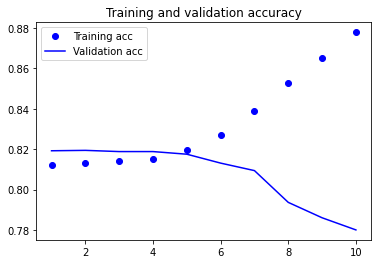

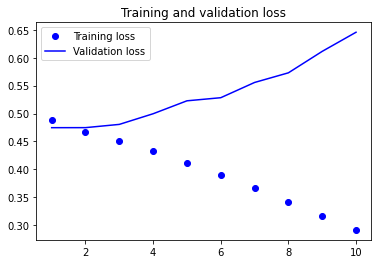

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Make a set of layers but keep the embedding layer unlocked

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 100)           1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,080,065
Trainable params: 1,080,065
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 368us/step - loss: 0.4777 - acc: 0.8123 - val_loss: 0.4636 - val_acc: 0.8193
Epoch 2/10
20000/20000 [==============================] - 7s 352us/step - loss: 0.4435 - acc: 0.8148 - val_loss: 0.4785 - val_acc: 0.8118
Epoch 3/10
20000/20000 [==============================] - 7s 348us/step - loss: 0.3881 - acc: 0.8378 - val_loss: 0.5236 - val_acc: 0.7906
Epoch 4/10
20000/20000 [==============================] - 7s 346us/step - loss: 0.3224 - acc: 0.8722 - val_loss: 0.5912 - val_acc: 0.7683
Epoch 5/10
20000/20000 [==============================] - 7s 354us/step - loss: 0.2699 - acc: 0.8943 - val_loss: 0.6599 - val_acc: 0.7519
Epoch 6/10
20000/20000 [==============================] - 7s 352us/step - loss: 0.2308 - acc: 0.9101 - val_loss: 0.7433 - val_acc: 0.7400
Epoch 7/10
20000/20000 [==============================] - 7s 352us/step - loss: 0.2031 - acc: 0.9230 - val_loss: 0.8317 - 

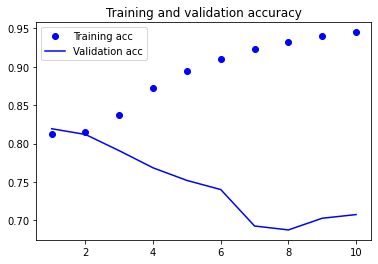

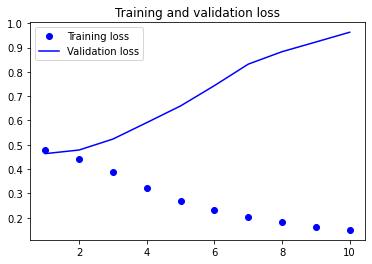

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Further ways to improve this model would be include other factors such as the number of views on the question, the tags, or even the rateing of the question owner. 

Simple data such as the views or the rating could be done using a dense network. Data such as the tags might also be used in a dense network by using a dictionary.

The results of these models could be merged to improve accuracy even further.



---


We can try training on view count:


In [ ]:
views = questions['view_count']


training_samples = 20000  # We will be training on 20k samples
validation_samples = 10000  # We will be validating on 10k samples


x_train_views = views[:training_samples]
y_train_views = labels[:training_samples]
x_val_views = views[training_samples: training_samples + validation_samples]
y_val_views = labels[training_samples: training_samples + validation_samples]

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_views,
                    y_train_views,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val_views, y_val_views))

Train on 20000 samples, validate on 10000 samples
Epoch 1/20
20000/20000 [==============================] - 0s 7us/step - loss: 1285.4128 - accuracy: 0.3964 - val_loss: 24.2558 - val_accuracy: 0.8193
Epoch 2/20
20000/20000 [==============================] - 0s 4us/step - loss: 29.6592 - accuracy: 0.6993 - val_loss: 26.0409 - val_accuracy: 0.8193
Epoch 3/20
20000/20000 [==============================] - 0s 4us/step - loss: 32.7861 - accuracy: 0.7021 - val_loss: 8.6900 - val_accuracy: 0.8193
Epoch 4/20
20000/20000 [==============================] - 0s 4us/step - loss: 33.7133 - accuracy: 0.7025 - val_loss: 23.3248 - val_accuracy: 0.8193
Epoch 5/20
20000/20000 [==============================] - 0s 4us/step - loss: 35.1141 - accuracy: 0.6862 - val_loss: 22.3408 - val_accuracy: 0.8193
Epoch 6/20
20000/20000 [==============================] - 0s 4us/step - loss: 31.8603 - accuracy: 0.7049 - val_loss: 22.8808 - val_accuracy: 0.8193
Epoch 7/20
20000/20000 [==============================] - 0s 

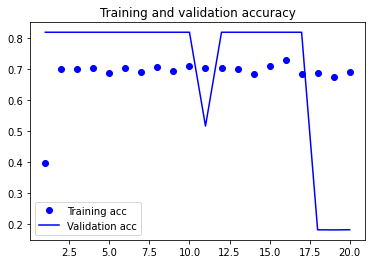

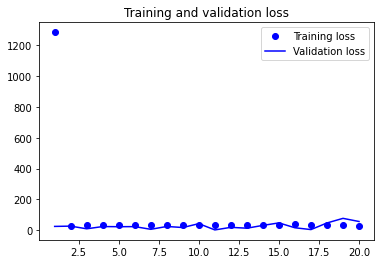

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Or Answer Count

In [ ]:
answer_count = questions['answer_count']

training_samples = 20000  # We will be training on 20k samples
validation_samples = 10000  # We will be validating on 10k samples


x_train_answer_count = views[:training_samples]
y_train_answer_count = labels[:training_samples]
x_val_answer_count = views[training_samples: training_samples + validation_samples]
y_val_answer_count = labels[training_samples: training_samples + validation_samples]

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_answer_count,
                    y_train_answer_count,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val_answer_count, y_val_answer_count))

Train on 20000 samples, validate on 10000 samples
Epoch 1/20
20000/20000 [==============================] - 0s 8us/step - loss: 9701.4851 - accuracy: 0.1870 - val_loss: 2584.4592 - val_accuracy: 0.1807
Epoch 2/20
20000/20000 [==============================] - 0s 4us/step - loss: 2138.6917 - accuracy: 0.2666 - val_loss: 32.1175 - val_accuracy: 0.8193
Epoch 3/20
20000/20000 [==============================] - 0s 4us/step - loss: 26.0391 - accuracy: 0.7110 - val_loss: 15.4183 - val_accuracy: 0.8193
Epoch 4/20
20000/20000 [==============================] - 0s 4us/step - loss: 30.9744 - accuracy: 0.6909 - val_loss: 58.3521 - val_accuracy: 0.1823
Epoch 5/20
20000/20000 [==============================] - 0s 4us/step - loss: 30.6095 - accuracy: 0.6771 - val_loss: 19.9285 - val_accuracy: 0.8193
Epoch 6/20
20000/20000 [==============================] - 0s 4us/step - loss: 29.8192 - accuracy: 0.7102 - val_loss: 9.3729 - val_accuracy: 0.8193
Epoch 7/20
20000/20000 [==============================] -

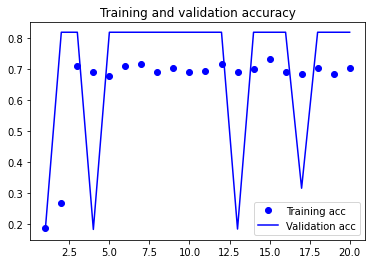

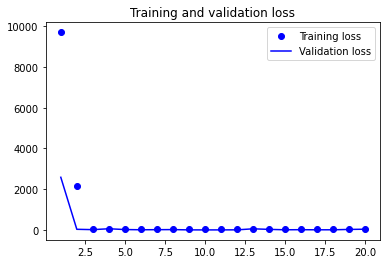

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Or Owner Reputation

In [ ]:
owner_rep = questions['ower_rep']
training_samples = 20000  # We will be training on 20k samples
validation_samples = 10000  # We will be validating on 10k samples


x_train_rep = views[:training_samples]
y_train_rep = labels[:training_samples]
x_val_rep = views[training_samples: training_samples + validation_samples]
y_val_rep = labels[training_samples: training_samples + validation_samples]

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_rep,
                    y_train_rep,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val_rep, y_val_rep))

Train on 20000 samples, validate on 10000 samples
Epoch 1/20
20000/20000 [==============================] - 0s 8us/step - loss: 1343.3802 - accuracy: 0.3272 - val_loss: 1.7746 - val_accuracy: 0.8193
Epoch 2/20
20000/20000 [==============================] - 0s 4us/step - loss: 22.1659 - accuracy: 0.6676 - val_loss: 36.9417 - val_accuracy: 0.8193
Epoch 3/20
20000/20000 [==============================] - 0s 4us/step - loss: 28.7697 - accuracy: 0.7036 - val_loss: 22.1649 - val_accuracy: 0.8193
Epoch 4/20
20000/20000 [==============================] - 0s 4us/step - loss: 26.5766 - accuracy: 0.6921 - val_loss: 25.6749 - val_accuracy: 0.8193
Epoch 5/20
20000/20000 [==============================] - 0s 4us/step - loss: 26.3158 - accuracy: 0.7128 - val_loss: 89.0643 - val_accuracy: 0.1807
Epoch 6/20
20000/20000 [==============================] - 0s 4us/step - loss: 23.7329 - accuracy: 0.6709 - val_loss: 3.9286 - val_accuracy: 0.8193
Epoch 7/20
20000/20000 [==============================] - 0s 4

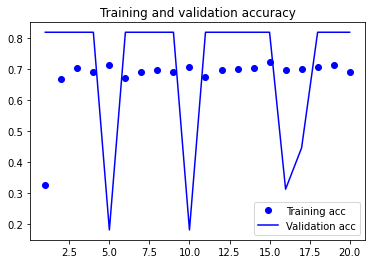

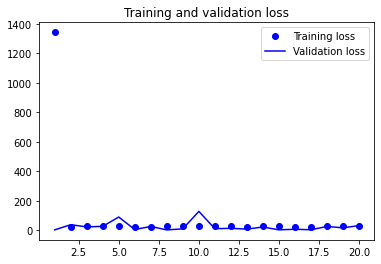

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



---


We can concatenate these models so that we improve the performance of the model by incorporating more data

In [ ]:
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers import Dense, Input

#View Count
model1_in = Input(shape=(1,))
model1_mid = Dense(16, activation='relu')(model1_in)
model1_out = Dense(16, activation='relu')(model1_mid)
model1 = Model(model1_in, model1_mid, model1_out)

#Answer Count
model2_in = Input(shape=(1,))
model2_mid = Dense(16, activation='relu')(model2_in)
model2_out = Dense(16, activation='relu')(model2_mid)
model2 = Model(model2_in, model2_mid, model2_out)

#Owner Rep
model3_in = Input(shape=(1,))
model3_mid = Dense(16, activation='relu')(model3_in)
model3_out = Dense(16, activation='relu')(model3_mid)
model3 = Model(model3_in, model3_mid, model3_out)


concatenated = concatenate([model1_out, model2_out, model3_out])
out = Dense(1, activation='sigmoid', name='output_layer')(concatenated)

merged_model = Model([model1_in, model2_in, model3_in], out)
merged_model.compile(loss='binary_crossentropy', optimizer='adam', 
metrics=['accuracy'])

history = merged_model.fit([x_train_views, x_train_answer_count, x_train_rep], y=y_train, epochs=20,  validation_data=([x_val_views,x_val_answer_count,x_val_rep], y_val))

Using TensorFlow backend.


NameError: ignored

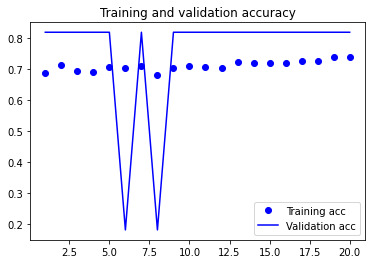

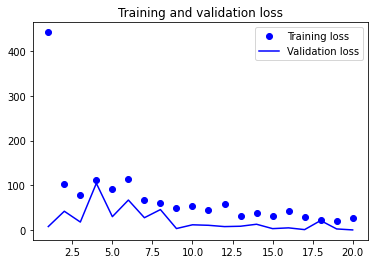

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This is still broken. Not sure how to concatenate embedding layers yet

In [ ]:
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers import Dense, Input

model_in = Embedding(max_words, embedding_dim, input_length=maxlen)
model_mid = Flatten()
model_mid2 = Dense(32, activation='relu')
model_out = Dense(1, activation='sigmoid')
model = Model(model_in, model_mid, model_mid2, model_out)

#View Count
model1_in = Input(shape=(1,))
model1_mid = Dense(16, activation='relu')(model1_in)
model1_out = Dense(16, activation='relu')(model1_mid)
model1 = Model(model1_in, model1_mid, model1_out)

#Answer Count
model2_in = Input(shape=(1,))
model2_mid = Dense(16, activation='relu')(model2_in)
model2_out = Dense(16, activation='relu')(model2_mid)
model2 = Model(model2_in, model2_mid, model2_out)

#Owner Rep
model3_in = Input(shape=(1,))
model3_mid = Dense(16, activation='relu')(model3_in)
model3_out = Dense(16, activation='relu')(model3_mid)
model3 = Model(model3_in, model3_mid, model3_out)


concatenated = concatenate([model_out,model1_out, model2_out, model3_out])
out = Dense(1, activation='sigmoid', name='output_layer')(concatenated)

merged_model = Model([model_in, model1_in, model2_in, model3_in], out)
merged_model.compile(loss='binary_crossentropy', optimizer='adam', 
metrics=['accuracy'])

history = merged_model.fit([x_train,x_train_views, x_train_answer_count, x_train_rep], y=y_train, epochs=20,  validation_data=([x_val,x_val_views,x_val_answer_count,x_val_rep], y_val))